In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

import sys
sys.path.append("../") # go to parent dir
from samplers import memory_mnist, memory_fashion
from utils import expspace


In [2]:
for i in memory_mnist(128, 32, 1)[0]:
    print(i.shape)
    break

torch.Size([128, 1, 32, 32])


In [3]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=False):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    ind_sort = np.argsort(data_clean[:,0])
    data_clean = data_clean[ind_sort]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
#     print(d)
    
    if log:
        d = np.log(d)
    regr = linear_model.TheilSenRegressor()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [4]:
image_size = 64
n_channels = 3
n_pixel = image_size * image_size * n_channels
val_flag = True

n = 7
cls = 0
min_noise = 0.01
max_noise = 0.1

In [5]:
train_loader, val_loader, train_val_loader, train_labels, val_labels, train_val_labels = memory_fashion(
    1, 32, 1, return_y=True
)
# train_loader, val_loader, train_val_loader, train_labels, val_labels, train_val_labels = memory_mnist(
#     1, 32, 1, return_y=True
# )

# fnames = sorted(glob(f"../entropia/mnist-repaired/ll_*_{n}.*"))
# fnames = sorted(glob(f"../entropia/mnist-seq/seq_ll_*0.txt"))
# fnames = sorted(glob(f"../entropia/fashion-mnist/ll_*_{n}.*"))
# fnames = sorted(glob(f"../entropia/fashion-seq/seq_ll_*0.txt"))
# fnames = sorted(glob(f"../entropia/fashion-mnist-dequant/ll_*_{n}.txt"))
fnames = sorted(glob(f"../entropia/fashion-mnist-no-dequant/ll_*_{n}.txt"))

# fnames = [f for f in fnames if int(f.split("_")[-1].split(".")[0])>=50]
len(fnames)

16

0: 1: 2: 3: 4: 5: 6: 7: 8: 9: 

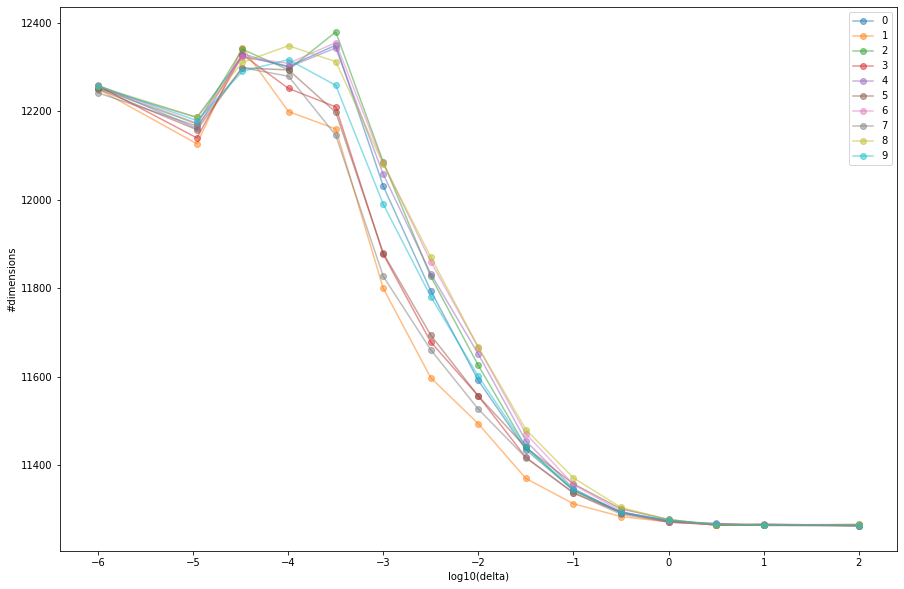

In [6]:
plt.figure(figsize=(15,10))
for cls in range(10):
    print(cls, end=": ")
    to_plot = []
    for f in fnames:
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt[val_labels.numpy() == cls]
        else:
            txt = txt[train_labels[-5000:].numpy() == cls]
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        else:
            noise, _, _, pz, logdet = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot) + 1e-6
#     print(to_plot)
    coef_list = [calculate_coeff(to_plot, i, i+2, log=True, plot=False) for i in range(len(to_plot)-1)]
    plt.plot(np.sort(np.log10(to_plot[:(len(to_plot)-1),0])), n_pixel - np.array(coef_list), 'o-',label=cls, alpha=0.5)
    plt.xlabel("log10(delta)")
    plt.ylabel("#dimensions")
#     coef = calculate_coeff(to_plot, 7, 11, log=True, plot=False, show=False)
#     print(n_pixel - coef)
plt.legend();
# length = 2
# dims = []
# for i in range(0, len(to_plot)-length+1):
#     coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
#     dims.append(n_pixel - coef)
# plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

In [7]:
txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, 7, 10, log=True, plot=False)
    dims.append(n_pixel - coef)


0
1000
2000
3000
4000


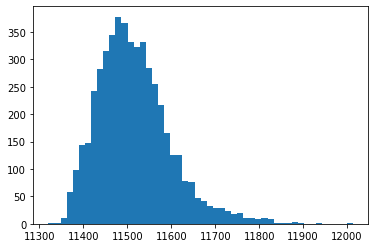

In [8]:
plt.hist(dims, bins=50);

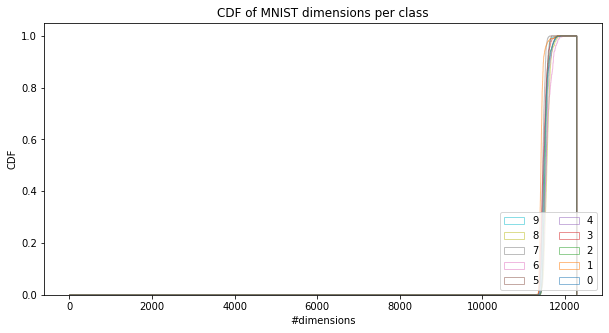

In [9]:
plt.figure(figsize=(10,5))
dims = np.array(dims)
datasets = []
for cls in range(10):
    if val_flag:
        datasets.append(dims[val_labels.numpy() == cls])
    else:
        datasets.append(dims[train_labels[50000:].numpy() == cls])
        
plt.hist(datasets, bins=np.linspace(0, 64*64*3, 10000), label=list(map(str, list(range(10)))), stacked=False,
        histtype="step", cumulative=True, alpha=0.5, density=True);

# plt.xlim(0, 600)
plt.legend(loc="lower right", ncol=2)
plt.title("CDF of MNIST dimensions per class")
plt.xlabel("#dimensions")
plt.ylabel("CDF");

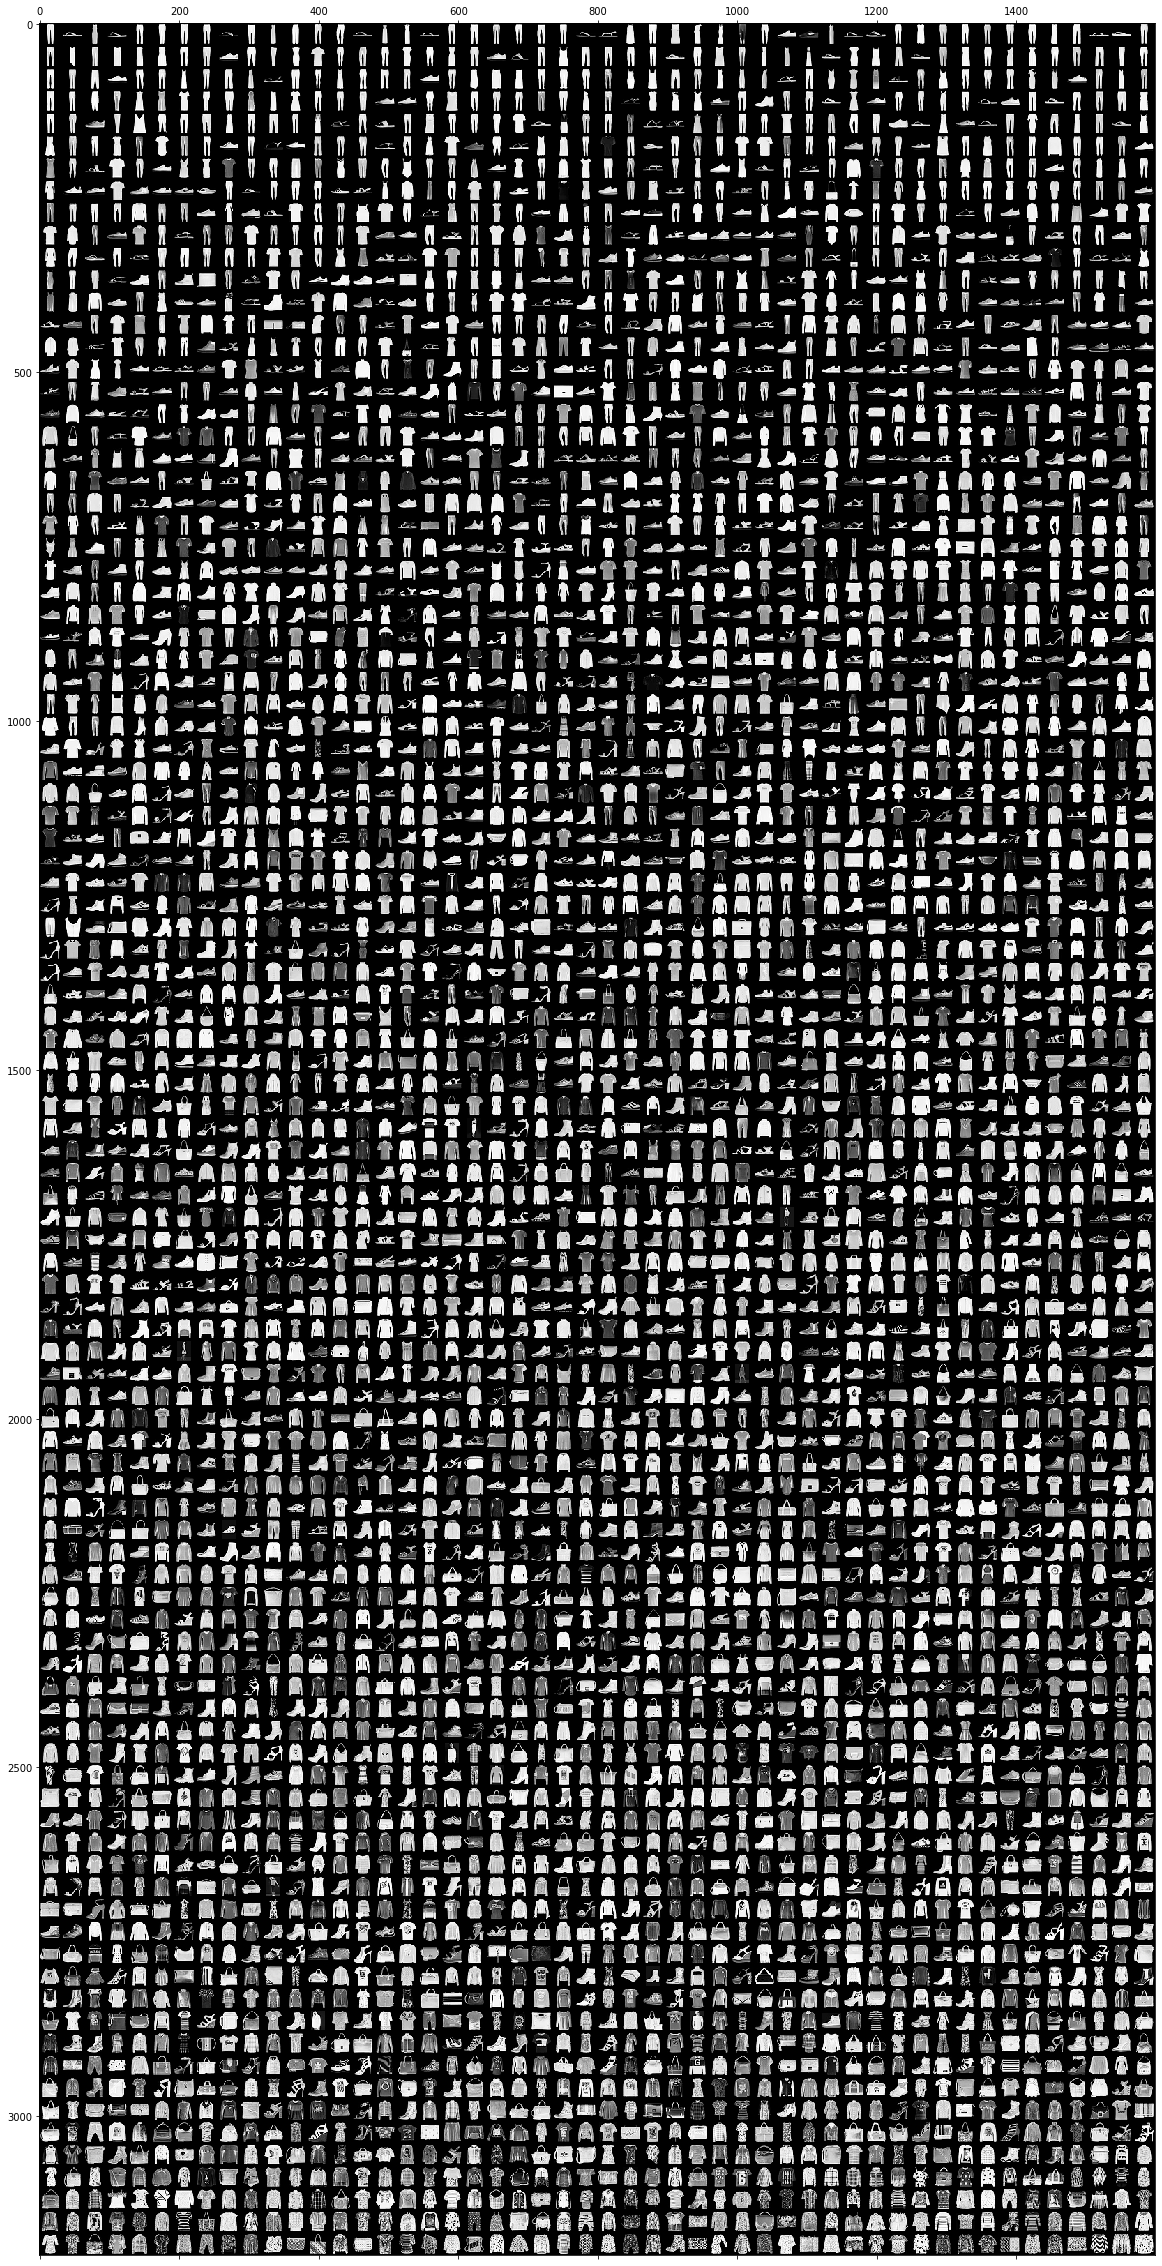

In [10]:
plt.figure(figsize=(20, 40))
m = 50
img_list = []
for i in range(0, 5000, m):
    imgs = []
    for j in range(m):
        ind = dims.argsort()[i + j]
        if val_flag:
            imgs.append(val_loader.dataset[ind][0])
        else:
            imgs.append(train_loader.dataset.tensors[50000:][ind])
    imgs = np.concatenate(imgs, axis=1)
    img_list.append(imgs)
plt.matshow(-np.concatenate(img_list, axis=0), fignum=1, cmap="Greys")
plt.show()

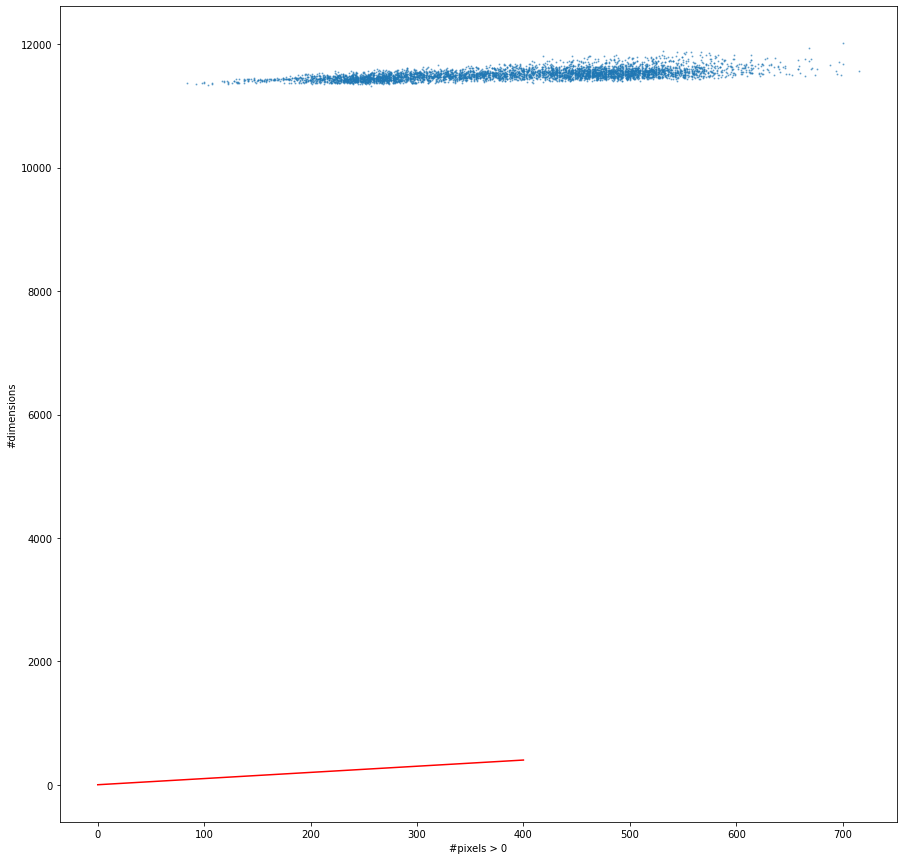

In [11]:
n_pix = []
for i in range(5000):
    n_pix.append((val_loader.dataset.tensors[i] > 0).sum().item())

plt.figure(figsize=(15,15))
plt.scatter(n_pix, dims, s=1, alpha=0.5)
plt.plot([0,400],[0,400], c='r')
plt.xlabel("#pixels > 0")
plt.ylabel("#dimensions");

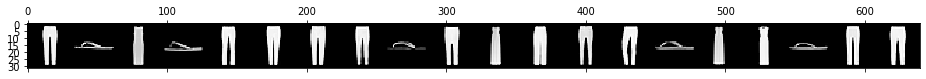

In [12]:
m = 20
imgs = []
for i in dims.argsort()[:m]:
    imgs.append(val_loader.dataset[i][0])

plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

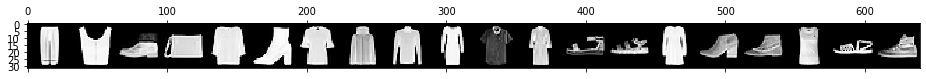

In [13]:
imgs = []
for i in dims.argsort()[2000:(2000+m)]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

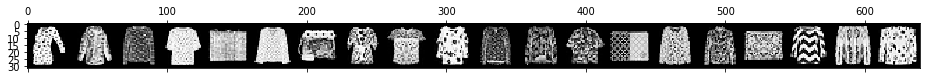

In [14]:
imgs = []
for i in dims.argsort()[-m:]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(-np.concatenate(imgs, axis=1), cmap="Greys")
plt.show()

In [15]:
def expspace(start, end, num):
    space = np.linspace(np.log(start), np.log(end), num)
    space = np.exp(space)
    return space

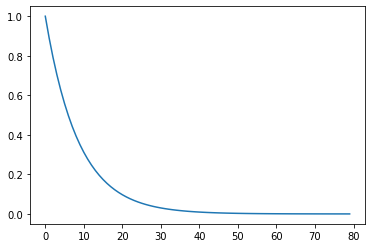

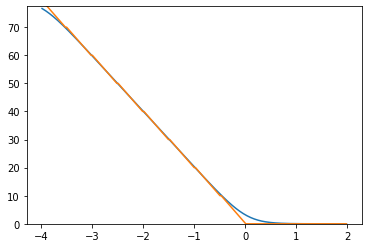

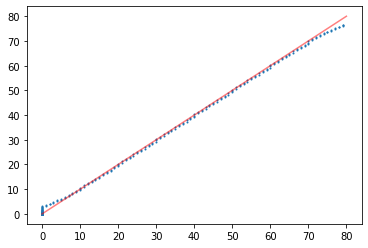

In [16]:
# sigma = [0] * 70 + [1] * 10
# sigma = np.linspace(1, 0, 80)
sigma = expspace(1, 0.0001, 80)
# sigma = 1 - expspace(1, 0.0001, 80)

plt.plot(sigma)
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.0001, 100, 250):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2)
plt.ylim(0, np.max(dims) * 1.01);
plt.show()
plt.scatter(delta_dim[:-1], dims, s=1)
plt.plot([0, 80],[0, 80], c='r', alpha=0.5)
# dims

In [17]:
l = 1/256
var = 1/12*(l)**2
sd = np.sqrt(var)
sd

0.0011276372445109878

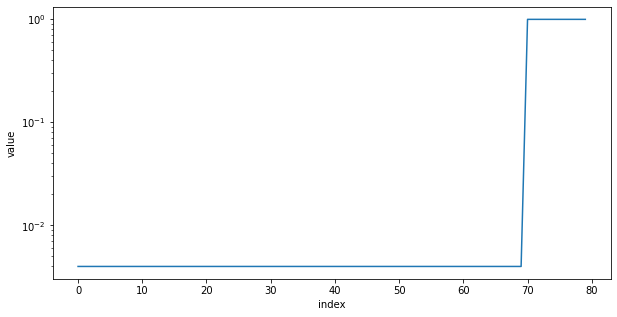

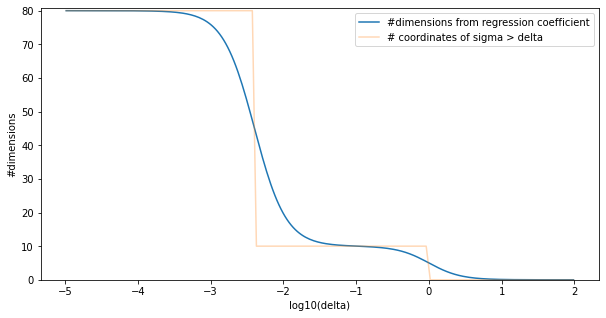

In [18]:
# low = 0.00113
low = 0.004
high = 1
sigma = [low] * 70 + [high] * 10
# sigma = np.linspace(1, 0, 80)

plt.figure(figsize=(10,5))
plt.plot(sigma)
plt.xlabel("index")
plt.ylabel("value")
plt.yscale("log")
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.00001, 100, 250):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.figure(figsize=(10,5))
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims, label="#dimensions from regression coefficient")
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2, alpha=0.3, label="# coordinates of sigma > delta")
plt.xlabel("log10(delta)")
plt.ylabel("#dimensions")
plt.ylim(0, np.max(dims) * 1.01);
plt.legend()

In [21]:
import numpy as np
10**(-1.1)

0.07943282347242814

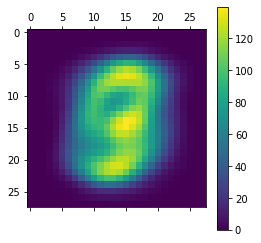

In [303]:
plt.matshow(train_loader.dataset.tensors.float().mean(axis=0))
plt.colorbar()

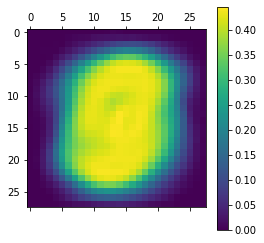

In [329]:
plt.matshow((train_loader.dataset.tensors.float()/255).std(axis=0))
plt.colorbar()

In [330]:
np.random.uniform(low=0, high=1/256, size=10000).std()

0.00112185726987694

In [333]:
10**(-1.5)

0.03162277660168379

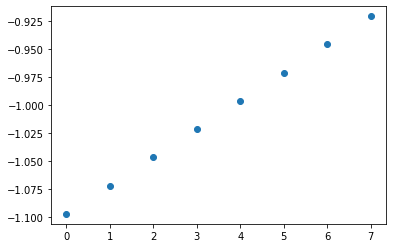

0.080000 0.084771 0.089826 0.095183 0.100859 0.106873 0.113247 0.120000 

In [23]:
noises = expspace(0.08, 0.12, 8)
plt.plot(np.log10(noises), 'o')
plt.show()
for i in noises:
    print(f"{i:.6f}", end=" ")

In [45]:
10.0**(-0.8)

0.15848931924611134

In [7]:
from torch.utils.data import DataLoader

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
bs = 32
dl = DataLoader(list(zip(train_loader, train_labels)), batch_size=bs)

In [42]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(dl, 0):
        inputs, labels = data
        
        inputs = inputs.reshape(inputs.shape[0], 1, 32, 32)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            outputs = []
            for inputs in val_loader:
                outputs.append(net(inputs).argmax().item())
            preds = torch.tensor(outputs)
            acc = (preds == val_labels).float().numpy().mean()
            print('[%d, %5d] loss: %.4f, acc: %.2f' %
                  (epoch + 1, i + 1, running_loss / 2000, acc))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.1478, acc: 0.35
[2,  1000] loss: 0.3834, acc: 0.76
[3,  1000] loss: 0.3024, acc: 0.79
[4,  1000] loss: 0.2628, acc: 0.81
[5,  1000] loss: 0.2391, acc: 0.83
[6,  1000] loss: 0.2225, acc: 0.83
[7,  1000] loss: 0.2084, acc: 0.84
[8,  1000] loss: 0.1967, acc: 0.85
[9,  1000] loss: 0.1870, acc: 0.85
[10,  1000] loss: 0.1786, acc: 0.86
[11,  1000] loss: 0.1712, acc: 0.86
[12,  1000] loss: 0.1651, acc: 0.86
[13,  1000] loss: 0.1600, acc: 0.86
[14,  1000] loss: 0.1553, acc: 0.87
[15,  1000] loss: 0.1509, acc: 0.87
[16,  1000] loss: 0.1470, acc: 0.87
[17,  1000] loss: 0.1431, acc: 0.87
[18,  1000] loss: 0.1396, acc: 0.87
[19,  1000] loss: 0.1366, acc: 0.87
[20,  1000] loss: 0.1333, acc: 0.87
[21,  1000] loss: 0.1304, acc: 0.88
[22,  1000] loss: 0.1277, acc: 0.88
[23,  1000] loss: 0.1251, acc: 0.88
[24,  1000] loss: 0.1224, acc: 0.88
[25,  1000] loss: 0.1201, acc: 0.88
[26,  1000] loss: 0.1178, acc: 0.88
[27,  1000] loss: 0.1155, acc: 0.89
[28,  1000] loss: 0.1132, acc: 0.88
[

In [43]:
outputs = []
for inputs in val_loader:
    outputs.append(net(inputs))

In [44]:
import torch
preds = torch.tensor([o.argmax().item() for o in outputs])

In [45]:
good = (preds == val_labels).int().numpy()

In [46]:
dims_score = -np.array(dims)

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

In [48]:
roc_auc_score(good, dims_score)

0.650203226945796

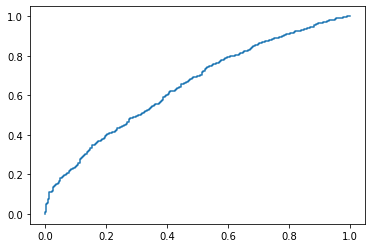

In [49]:
tpr, fpr, _ = roc_curve(good, dims_score)

plt.plot(tpr, fpr)